In [16]:
import pandas as pd
import numpy as np
import re, random
from cleantext import clean

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
data = pd.read_csv("../../data/english_dataset/english_dataset.tsv",sep="\t").sample(frac=1)
data.head()

,text_id,text,task_1,task_2,task_3
4900,hasoc_en_4901,I was asleep and you are a dickhead. #dickhead...,HOF,PRFN,TIN
5344,hasoc_en_5345,DON'T #Retweet This Because Trump's Lies Will ...,NOT,NONE,NONE
1647,hasoc_en_1648,Translation- 'Even after continuous inaction b...,NOT,NONE,NONE
4849,hasoc_en_4850,@MedCrisis Not only in Kolkata my friend. Take...,HOF,OFFN,UNT
5170,hasoc_en_5171,@realDonaldTrump #DerangedDonald LOST THE POPU...,NOT,NONE,NONE


In [18]:
test_data = pd.read_csv("../../data/english_dataset/hasoc2019_en_test-2919.tsv", sep="\t").sample(frac=1)
test_data.head()

,text_id,text,task_1,task_2,task_3
178,hasoc_en_477,#sharethetrophy #yeswekane ICC retains #kumard...,NOT,NONE,NONE
153,hasoc_en_996,Mamata Didi refused to meet Governor and other...,NOT,NONE,NONE
1034,hasoc_en1_4504,Be your own inspiration! Burpees are someth...,NOT,NONE,NONE
172,hasoc_en_991,Sometimes they try but end up looking even mor...,HOF,HATE,TIN
802,hasoc_en_394,"These bans have had very real consequences, sp...",NOT,NONE,NONE


In [19]:
def create_label(labels, data):
    return data.map(labels, na_action='ignore')

### cleaning the text 

In [20]:
def text_clean(text):
    return clean(text,
    fix_unicode=True,               # fix various unicode errors
    to_ascii=True,                  # transliterate to closest ASCII representation
    lower=True,                     # lowercase text
    no_line_breaks=False,           # fully strip line breaks as opposed to only normalizing them
    no_urls=False,                  # replace all URLs with a special token
    no_emails=False,                # replace all email addresses with a special token
    no_phone_numbers=False,         # replace all phone numbers with a special token
    no_numbers=False,               # replace all numbers with a special token
    no_digits=False,                # replace all digits with a special token
    no_currency_symbols=False,      # replace all currency symbols with a special token
    no_punct=True,                 # remove punctuations
    replace_with_url="<URL>",
    replace_with_email="<EMAIL>",
    replace_with_phone_number="<PHONE>",
    replace_with_number="<NUMBER>",
    replace_with_digit="0",
    replace_with_currency_symbol="<CUR>",
    lang="en"                       # set to 'de' for German special handling
)

In [22]:
vocab_size = 5000
embedding_dim = 64
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

### Tokenization

In [23]:
def get_tokenize(data):
    tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
    tokenizer.fit_on_texts(data)
    word_index = tokenizer.word_index
    return tokenizer, word_index 

### Creating a Bi-LSTM consisting of Embedding and a Dense Layer

In [42]:
def create_model(n_class):
    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(n_class+1, activation='softmax')
])
    return model

### Training the model for a classification task

In [57]:
def make_train(model, train_padded, training_label_seq, test_padded, test_label_seq, val_padded, val_label_seq, target, epochs=5, batch_size=32):
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(train_padded, training_label_seq, epochs=epochs, validation_data=(val_padded, val_label_seq), verbose=2)
    y_pred = np.argmax(model.predict(test_padded), axis=-1)
    print("==== CLASSIFICATION REPORT ========= \n", classification_report(test_label_seq, y_pred, target_names=target))
    print("==== CONFUSION MATRIX ==== \n", confusion_matrix(test_label_seq, y_pred))
    return history.history, epochs

### Class labels

In [60]:
# label_task1, label_task2, label_task3 = {'NOT': 0, 'HOF': 1}, {'HATE':0, 'OFFN':1, 'PRFN':2}, {'TIN':0, 'UNT':1}
label = [{'NOT': 0, 'HOF': 1}, {'HATE':0, 'OFFN':1, 'PRFN':2, 'NONE':3}, {'TIN':0, 'UNT':1, 'NONE':2}]

### Running the model on all 3 tasks and plotting their loss and accuracy

Epoch 1/5
123/123 - 10s - loss: 0.7087 - accuracy: 0.6110 - val_loss: 0.6636 - val_accuracy: 0.6108
Epoch 2/5
123/123 - 6s - loss: 0.6078 - accuracy: 0.6676 - val_loss: 0.6238 - val_accuracy: 0.6423
Epoch 3/5
123/123 - 6s - loss: 0.4507 - accuracy: 0.7911 - val_loss: 0.6707 - val_accuracy: 0.6330
Epoch 4/5
123/123 - 7s - loss: 0.3241 - accuracy: 0.8666 - val_loss: 0.8145 - val_accuracy: 0.6237
Epoch 5/5
123/123 - 7s - loss: 0.2241 - accuracy: 0.9138 - val_loss: 1.0958 - val_accuracy: 0.6253
==== CLASSIFICATION REPORT ========= 
               precision    recall  f1-score   support

         NOT       0.86      0.69      0.77       865
         HOF       0.42      0.67      0.52       288

    accuracy                           0.69      1153
   macro avg       0.64      0.68      0.64      1153
weighted avg       0.75      0.69      0.71      1153

==== CONFUSION MATRIX ==== 
 [[600 265]
 [ 96 192]]


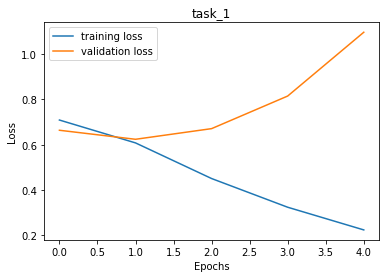

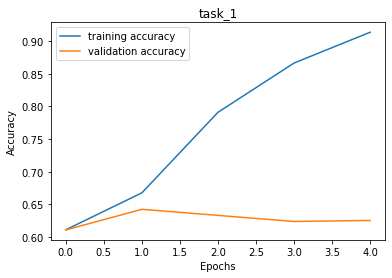

Epoch 1/5
123/123 - 9s - loss: 1.1148 - accuracy: 0.6079 - val_loss: 1.0707 - val_accuracy: 0.6108
Epoch 2/5
123/123 - 7s - loss: 0.9541 - accuracy: 0.6222 - val_loss: 0.9849 - val_accuracy: 0.6237
Epoch 3/5
123/123 - 9s - loss: 0.7260 - accuracy: 0.7125 - val_loss: 1.0524 - val_accuracy: 0.5776
Epoch 4/5
123/123 - 9s - loss: 0.5213 - accuracy: 0.7923 - val_loss: 1.1845 - val_accuracy: 0.5864
Epoch 5/5
123/123 - 9s - loss: 0.3756 - accuracy: 0.8630 - val_loss: 1.4367 - val_accuracy: 0.5497
==== CLASSIFICATION REPORT ========= 
               precision    recall  f1-score   support

        HATE       0.82      0.71      0.76       865
        OFFN       0.17      0.38      0.23       124
        PRFN       0.52      0.49      0.51        93
        NONE       0.13      0.06      0.08        71

    accuracy                           0.62      1153
   macro avg       0.41      0.41      0.39      1153
weighted avg       0.68      0.62      0.64      1153

==== CONFUSION MATRIX ==== 
 [[

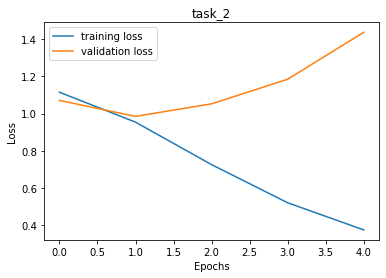

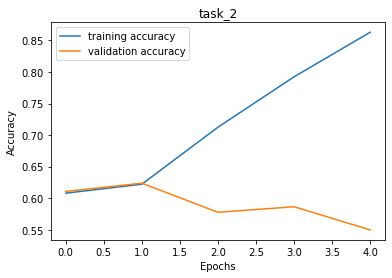

Epoch 1/5
123/123 - 15s - loss: 0.8502 - accuracy: 0.6112 - val_loss: 0.8150 - val_accuracy: 0.6108
Epoch 2/5
123/123 - 12s - loss: 0.7315 - accuracy: 0.6556 - val_loss: 0.7574 - val_accuracy: 0.6460
Epoch 3/5
123/123 - 11s - loss: 0.5705 - accuracy: 0.7714 - val_loss: 0.8526 - val_accuracy: 0.6506
Epoch 4/5
123/123 - 11s - loss: 0.4227 - accuracy: 0.8434 - val_loss: 1.0207 - val_accuracy: 0.6227
Epoch 5/5
123/123 - 13s - loss: 0.2876 - accuracy: 0.8974 - val_loss: 1.1617 - val_accuracy: 0.6102
==== CLASSIFICATION REPORT ========= 
               precision    recall  f1-score   support

         TIN       0.84      0.75      0.79       865
         UNT       0.37      0.56      0.44       245
        NONE       0.00      0.00      0.00        43

    accuracy                           0.68      1153
   macro avg       0.40      0.43      0.41      1153
weighted avg       0.71      0.68      0.69      1153

==== CONFUSION MATRIX ==== 
 [[647 209   9]
 [104 136   5]
 [ 21  22   0]]


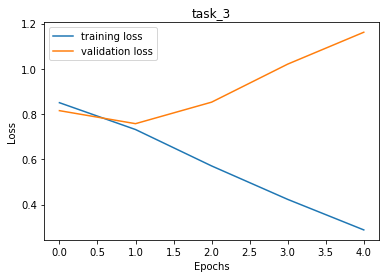

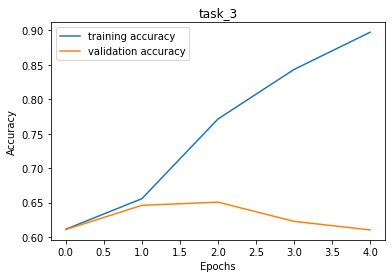

In [61]:
for i in range(1,4):
    col = "task_"+str(i)
#     y = create_label(label[i-1], data[col])
    x, y = data['text'], data[col]
    
    X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.33, random_state=42)
    X_test, y_test = test_data['text'], test_data[col]
    
    train_data_clean = X_train.apply(lambda row : text_clean(row))
    test_data_clean = X_test.apply(lambda row : text_clean(row))
    val_data_clean = X_val.apply(lambda row : text_clean(row))
  
    tokenizer, word_index  = get_tokenize(train_data_clean)
    train_sequences = tokenizer.texts_to_sequences(train_data_clean)
    train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
        
    
    test_sequences = tokenizer.texts_to_sequences(test_data_clean)
    test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

    
    val_sequences = tokenizer.texts_to_sequences(val_data_clean)
    val_padded = pad_sequences(val_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    
    
    label_tokenizer = Tokenizer()
    label_tokenizer.fit_on_texts(y_train)

    training_label_seq = np.array(label_tokenizer.texts_to_sequences(y_train))
    test_label_seq = np.array(label_tokenizer.texts_to_sequences(y_test))
    val_label_seq = np.array(label_tokenizer.texts_to_sequences(y_val))
  
    model = create_model(n_class = len(label[i-1]))
    history, epochs = make_train(model, train_padded, training_label_seq, test_padded, test_label_seq, val_padded, val_label_seq, list(label[i-1].keys()), epochs=5, batch_size=32)
    
    
    p_y = np.arange(epochs)
    plt.plot(p_y, history['loss'])
    plt.plot(p_y, history['val_loss'])
    plt.legend(['training loss','validation loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(col)
    plt.show()
    
    plt.plot(p_y, history['accuracy'])
    plt.plot(p_y, history['val_accuracy'])
    plt.legend(['training accuracy','validation accuracy'])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(col)
    plt.show()